In [1]:
import numpy as np
import newbridge as nb
%matplotlib inline
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from math import sqrt

In [2]:
# load data
import pickle
with open('nem.pkl','rb') as f:
    allx, allt = pickle.load(f)

In [3]:
print(allx.shape)
print(allt.shape)
print(allx.shape[0])

(101, 6)
(101, 6)
101


In [4]:
# plt.plot(allt[:,1], allx[:,1])

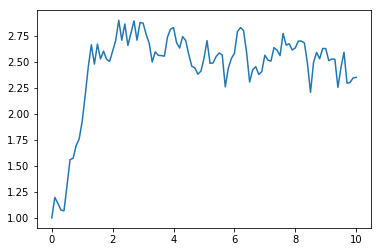

In [5]:
plt.plot(allt[:,0], allx[:,0])

In [6]:
# initial guess for theta
theta = np.array([1.5, 1., 0., -0.25])
dof = theta.shape[0]

# true diffusion coefficient
g = 0.5

In [7]:
numsubintervals = 10
h = (allt[1,0] - allt[0,0])/numsubintervals
numpaths = 1000
burninpaths = 100

In [8]:
def mcmc(burninpaths, numpaths, g, allx, allt, numsubintervals, i, j, h, theta, dof):
    mmat = np.zeros((dof, dof))
    rvec = np.zeros(dof)
    x = allx[:,j]
    t = allt[:,j]
    
    samples = np.zeros(numsubintervals)
    _, xcur = nb.brownianbridge(g,x,t,numsubintervals,i)
    oldlik = nb.girsanov(g=g, path=xcur, dt=h, theta=theta)
    arburn = np.zeros(burninpaths)
    arsamp = np.zeros(numpaths)
    for jj in range(burninpaths):
        _, prop = nb.brownianbridge(g,x,t,numsubintervals,i)
        proplik = nb.girsanov(g=g, path=prop, dt=h, theta=theta)
        rho = np.exp(proplik - oldlik)
        if (rho > np.random.uniform()):
            xcur = prop
            oldlik = proplik
            arburn[jj] = 1
#     print("Acceptance rate during burn-in:", np.mean(arburn))
    meanBurnin = np.mean(arburn)
    
    # for each path being sampled (r = 0 to r = R)
    arsamp = np.zeros(numpaths)
    for jj in range(numpaths):
        _, prop = nb.brownianbridge(g,x,t,numsubintervals,i)
        proplik = nb.girsanov(g=g, path=prop, dt=h, theta=theta)
        rho = np.exp(proplik - oldlik)
        if (rho > np.random.uniform()):
            xcur = prop
            oldlik = proplik
            arsamp[jj] = 1
        samples = xcur
        pp = nb.hermite_basis(samples[:(-1)])
        mmat = mmat + h * np.matmul(pp.T, pp) / numpaths
        rvec = rvec + np.matmul((np.diff(samples)).T, pp) / numpaths    
#     print("Acceptance rate post burn-in:", np.mean(arsamp))
    meanSample = np.mean(arsamp)
    
    return (mmat, rvec, meanBurnin, meanSample)

In [9]:
done = False
mytol = 1e-3
numiter = 0
while (done == False):
    numiter = numiter + 1
    print(numiter)
    mmat = np.zeros((dof, dof))
    rvec = np.zeros(dof)
    
    # for each interval of observed value (x_0 to x_n)
#     for wp in range(allx.shape[1]):
#         x = allx[:,wp]
#         t = allt[:,wp]
#         with Parallel(n_jobs=-1) as parallel:
#             results = parallel(delayed(mcmc)(burninpaths, numpaths, g, x, t, numsubintervals, i, h, theta, dof) 
#                             for i in range(x.shape[0] - 1))
#             for res in results:
#                 mmat += res[0]
#                 rvec += res[1]
#                 print("Acceptance rate during burn-in:", res[2])
#                 print("Acceptance rate post burn-in:", res[3])

    with Parallel(n_jobs=-1) as parallel:
        results = parallel(delayed(mcmc)(burninpaths, numpaths, g, allx, allt, numsubintervals, i, j, h, theta, dof) 
                        for (i, j) in zip(range(allx.shape[0] - 1), range(allx.shape[1])))

        for res in results:
            mmat += res[0]
            rvec += res[1]
            print("Acceptance rate during burn-in:", res[2])
            print("Acceptance rate post burn-in:", res[3])

    newtheta = np.linalg.solve(mmat, rvec)
    check = np.sum(np.abs(newtheta - theta))
    if (check < mytol):
        print("finished!")
        print(check)
        print(theta)
        done = True
    theta = newtheta
    print(check)
    print(theta)

1


JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/shagun/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/shagun/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fef47e5c8a0, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/shagun.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fef47e5c8a0, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/shagun.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-03-15T19:56:16.477887', 'msg_id': '7DEE02F789B543478303E946F7A981FA', 'msg_type': 'execute_request', 'session': '2E590A4F5B7545A5802D422026735A40', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7DEE02F789B543478303E946F7A981FA', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'2E590A4F5B7545A5802D422026735A40']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-03-15T19:56:16.477887', 'msg_id': '7DEE02F789B543478303E946F7A981FA', 'msg_type': 'execute_request', 'session': '2E590A4F5B7545A5802D422026735A40', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7DEE02F789B543478303E946F7A981FA', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'2E590A4F5B7545A5802D422026735A40'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-03-15T19:56:16.477887', 'msg_id': '7DEE02F789B543478303E946F7A981FA', 'msg_type': 'execute_request', 'session': '2E590A4F5B7545A5802D422026735A40', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7DEE02F789B543478303E946F7A981FA', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.While object>], cell_name='<ipython-input-9-18b0c042e834>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fef170f0978, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fef19891300, file "<ipython-input-9-18b0c042e834>", line 4>
        result = <ExecutionResult object at 7fef170f0978, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fef19891300, file "<ipython-input-9-18b0c042e834>", line 4>, result=<ExecutionResult object at 7fef170f0978, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fef19891300, file "<ipython-input-9-18b0c042e834>", line 4>
        self.user_global_ns = {'In': ['', 'import numpy as np\nimport newbridge as nb\nget_ip...ib import Parallel, delayed\nfrom math import sqrt', "# load data\nimport pickle\nwith open('nem.pkl','rb') as f:\n    allx, allt = pickle.load(f)", 'print(allx.shape)\nprint(allt.shape)\nprint(allx.shape[0])', '# plt.plot(allt[:,1], allx[:,1])', 'plt.plot(allt[:,0], allx[:,0])', '# initial guess for theta\ntheta = np.array([1.5,...ta.shape[0]\n\n# true diffusion coefficient\ng = 0.5', 'numsubintervals = 10\nh = (allt[1,0] - allt[0,0])/numsubintervals\nnumpaths = 1000\nburninpaths = 100', 'def mcmc(burninpaths, numpaths, g, allx, allt, n... \n    return (mmat, rvec, meanBurnin, meanSample)', 'done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)'], 'Out': {5: [<matplotlib.lines.Line2D object>]}, 'Parallel': <class 'joblib.parallel.Parallel'>, '_': [<matplotlib.lines.Line2D object>], '_5': [<matplotlib.lines.Line2D object>], '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
        self.user_ns = {'In': ['', 'import numpy as np\nimport newbridge as nb\nget_ip...ib import Parallel, delayed\nfrom math import sqrt', "# load data\nimport pickle\nwith open('nem.pkl','rb') as f:\n    allx, allt = pickle.load(f)", 'print(allx.shape)\nprint(allt.shape)\nprint(allx.shape[0])', '# plt.plot(allt[:,1], allx[:,1])', 'plt.plot(allt[:,0], allx[:,0])', '# initial guess for theta\ntheta = np.array([1.5,...ta.shape[0]\n\n# true diffusion coefficient\ng = 0.5', 'numsubintervals = 10\nh = (allt[1,0] - allt[0,0])/numsubintervals\nnumpaths = 1000\nburninpaths = 100', 'def mcmc(burninpaths, numpaths, g, allx, allt, n... \n    return (mmat, rvec, meanBurnin, meanSample)', 'done = False\nmytol = 1e-3\nnumiter = 0\nwhile (don...heta = newtheta\n    print(check)\n    print(theta)'], 'Out': {5: [<matplotlib.lines.Line2D object>]}, 'Parallel': <class 'joblib.parallel.Parallel'>, '_': [<matplotlib.lines.Line2D object>], '_5': [<matplotlib.lines.Line2D object>], '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/shagun/Desktop/research/pathsamp/newbridge/harish/<ipython-input-9-18b0c042e834> in <module>()
     20 #                 print("Acceptance rate during burn-in:", res[2])
     21 #                 print("Acceptance rate post burn-in:", res[3])
     22 
     23     with Parallel(n_jobs=-1) as parallel:
     24         results = parallel(delayed(mcmc)(burninpaths, numpaths, g, allx, allt, numsubintervals, i, j, h, theta, dof) 
---> 25                         for (i, j) in zip(range(allx.shape[0] - 1), range(allx.shape[1])))
     26 
     27         for res in results:
     28             mmat += res[0]
     29             rvec += res[1]

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Thu Mar 15 19:56:16 2018
PID: 852                    Python 3.6.0: /home/shagun/anaconda3/bin/python
...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function mcmc>, (100, 1000, 0.5, array([[ 1.        ,  0.9       ,  1.1       , -... -5.61006758, -5.57279065,
        -5.59454072]]), array([[  0. ,   0. ,   0. ,   0. ,   0. ,   0. ...     [ 10. ,  10. ,  10. ,  10. ,  10. ,  10. ]]), 10, 0, 0, 0.009999999999999962, array([ 1.5 ,  1.  ,  0.  , -0.25]), 4), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/shagun/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function mcmc>
        args = (100, 1000, 0.5, array([[ 1.        ,  0.9       ,  1.1       , -... -5.61006758, -5.57279065,
        -5.59454072]]), array([[  0. ,   0. ,   0. ,   0. ,   0. ,   0. ...     [ 10. ,  10. ,  10. ,  10. ,  10. ,  10. ]]), 10, 0, 0, 0.009999999999999962, array([ 1.5 ,  1.  ,  0.  , -0.25]), 4)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/shagun/Desktop/research/pathsamp/newbridge/harish/<ipython-input-8-62861a43bce3> in mcmc(burninpaths=100, numpaths=1000, g=0.5, allx=array([[ 1.        ,  0.9       ,  1.1       , -... -5.61006758, -5.57279065,
        -5.59454072]]), allt=array([[  0. ,   0. ,   0. ,   0. ,   0. ,   0. ...     [ 10. ,  10. ,  10. ,  10. ,  10. ,  10. ]]), numsubintervals=10, i=0, j=0, h=0.009999999999999962, theta=array([ 1.5 ,  1.  ,  0.  , -0.25]), dof=4)
     29         if (rho > np.random.uniform()):
     30             xcur = prop
     31             oldlik = proplik
     32             arsamp[jj] = 1
     33         samples = xcur
---> 34         pp = nb.hermite_basis(samples[:(-1)])
     35         mmat = mmat + h * np.matmul(pp.T, pp) / numpaths
     36         rvec = rvec + np.matmul((np.diff(samples)).T, pp) / numpaths    
     37 #     print("Acceptance rate post burn-in:", np.mean(arsamp))
     38     meanSample = np.mean(arsamp)

AttributeError: module 'newbridge' has no attribute 'hermite_basis'
___________________________________________________________________________

In [ ]:
def trial(dof, i, j):
    mmat = np.zeros((dof, dof))
    rvec = np.zeros(dof)
    return (mmat, rvec)

dof = 6
mmat = np.zeros((dof, dof))
rvec = np.zeros(dof)
numiter = 0
with Parallel(n_jobs=2) as parallel:
#     while numiter < 10:
    results = parallel(delayed(trial)(dof, i, j) for (i, j) in zip(range(5), range(2)))
    print(results)
    for res in results:
        mmat += res[0]
        rvec += res[1]
#             numiter += 1
#         print(mmat)
#         print(rvec)